### Magics

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
# Stuff for getting the tokenizer etc.
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor

# Need torch
import torch as tt

# Need numpy
import numpy as np

# Some plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns

# Need pillow for displaying images
from PIL import Image as PILImage

### Parameters etc.

Use mps for macs with M1, M2 or M3 chips.

In [3]:
device = "mps" 

### Some helper functions

Helper function that just loads a model and its tokenizer

In [4]:
def get_model(model_id,
             device = None,
             max_seq_length = 1024):

    tokenizer = AutoTokenizer.from_pretrained(model_id,
                                              max_length=max_seq_length,
                                              padding_side='left')

    if device is None:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=tt.bfloat16,
            device_map="auto",
        )
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=tt.bfloat16,
            device_map=device,
        )
        model.to(device)

    # Get the processor
    processor = AutoProcessor.from_pretrained(model_id)

    return tokenizer, model, processor

Helper function that will encode and decode a string using given tokenizer

In [5]:
def encode_and_decode(tokenizer, s):
  tokens = tokenizer.encode(s)
  decoded_tokens = [tokenizer.decode(t) for t in tokens]
  # Determine the length of the list of tokens minus the special tokens
  num_tokens = len([t for t in tokens if t not in tokenizer.all_special_ids])
  num_spec_tokens = len(tokens) - num_tokens
  # Prepare a report string
  report_str = f"String: \t\t{s}\nTokens: \t\t{tokens}\nDecoded tokens: \t{decoded_tokens}\nN tokens: \t\t{num_tokens}\nN spec. tokens: \t{num_spec_tokens}"
  return tokens, decoded_tokens, report_str, num_tokens, num_spec_tokens


Helper functions that will generate a prediction from a model

In [6]:
def generate_prediction_logits(pred_str, model, tokenizer, N = 20):

    # Encode the input string
    inputs = tokenizer(
        pred_str,
        return_tensors="pt",
        truncation=False,
    ).to(model.device)

    with tt.no_grad():
        logits = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        ).logits

        # Get the probability distribution over the vocabulary for the last token
        probs = tt.nn.functional.softmax(logits[:, -1, :], dim=-1)
        top_probs, top_indices = tt.topk(probs, k=N, dim=-1)

    return top_probs, top_indices, probs

In [7]:
def generate_prediction(pred_str, model, tokenizer, max_new_tokens = 1):

    # Encode the input string
    inputs = tokenizer(
        pred_str,
        return_tensors="pt",
        truncation=False,
    ).to(model.device)

    with tt.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens,
        )
    return inputs, outputs

Helper function to style plots, modify the colors to your liking

In [8]:
def style_plot(fig, ax,
               title,
               xlabel, ylabel,
               grid_color = 'lightgray', grid_linestyle = '--', grid_linewidth = 0.5,
               facecolor = (13/255, 43/255, 54/255),
               text_color = 'white',
               spine_color = 'white',
               line_color = 'lightgray'):
    # Add a title in white
    ax.set_title(title, color="white")
    # Add axis labels in white
    ax.set_xlabel(xlabel, color=text_color)
    ax.set_ylabel(ylabel, color=text_color)
    # Set the background color to a dark gray
    fig.patch.set_facecolor(facecolor)
    ax.set_facecolor(facecolor)
    # Set the grid color to a light gray
    ax.grid(color=grid_color, linestyle=grid_linestyle, linewidth=grid_linewidth)
    # Set the tick colors to white
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    # Set the spine color to white
    for spine in ax.spines.values():
        spine.set_edgecolor(spine_color)
    # Set the axis labels to white
    ax.yaxis.label.set_color(text_color)
    ax.xaxis.label.set_color(text_color)
    # Set the lines to the line color
    for line in ax.get_lines():
        line.set_color(line_color)

### Load a small  model

We will consider two models, the Llama-3.2-1B-Instruct model and the Qwen2.5-0.5B-Instruct model.
The models arent't the main point here, but the tokenizers are.

In [9]:
model_id_llama = "meta-llama/Llama-3.2-1B-Instruct"
model_id_qwen = "Qwen/Qwen2.5-0.5B-Instruct"

In [10]:
model_id = model_id_llama

In [11]:
tokenizer, model, processor = get_model(model_id, device = device)

### When training or finetuning a model, how is loss calculated?

Before we go further, it's important to understand how loss is calculated in a language model during training<br>
and/or finetuning.

Let's assume that we consider the string 

*"To be or not to be that is"*

and that we want to train (or finetune) the model to predict the continuation which should (most likely) be:

*"the question"*  

So in this case, the ground truth is *"the question"*.  In this case we essentially we provide the model with<br>
__two__ tasks:

1.  The model is fed "To be or not to be that is" and needs to predict "the" as the next token.
2.  The model is fed "To be or not to be that is the" and needs to predict "question" as the next token.

In each case, the model produces logits (unnormalized scores) for every token in its vocabulary. These logits are<br>
then converted to 'probabilities' using softmax.  Also, for the target token, we have a one-hot encoded<br>
vector with a length equal to the vocabulary size and with a 1 at the index of the target token and 0s elsewhere.

The loss is then (typically) calculated using cross-entropy loss between the predicted distribution and the true<br>
distribution.  The cross-entropy between two distributions $p$ (the ground truth distribution) and<br>
$q$ (the predicted distribution) is defined as:

$ \Large H(p, q) = -\sum_{i=1}^{n} p[i] \log(q[i]) $

Another and more productive way of thinking about this is that the loss function in this case is the negative log<br>
likelihood of the target token under the predicted distribution.

__Note carefully:__ This can be done in parallel, it is important to realise that we are now __not__ in inference<br>
mode, but in training mode.  In inference mode we generate tokens one by one, but in training mode we generate all<br>
tokens in parallel.  In inference mode we don't know the target token, so we have to generate it.  In training mode<br>
we do know the target token, so we can use teacher forcing.  Also, in inference mode we might choose to sample from<br>
the predicted distribution, but in training mode we don't.

Let's actually do this.  We will use the prediction string "To be or not to be that is the" and the ground truth string<br>
"question".  We will then encode the strings and calculate the loss.

In [12]:
pred_str = "To be or not to be that is the"
gt_str = " question"

Lets encode the strings

In [13]:
tokens, decoded_tokens, report_str, num_tokens, num_spec_tokens = encode_and_decode(tokenizer, pred_str)
print(report_str)

String: 		To be or not to be that is the
Tokens: 		[128000, 1271, 387, 477, 539, 311, 387, 430, 374, 279]
Decoded tokens: 	['<|begin_of_text|>', 'To', ' be', ' or', ' not', ' to', ' be', ' that', ' is', ' the']
N tokens: 		9
N spec. tokens: 	1


In [14]:
tokens, decoded_tokens, report_str, num_tokens, num_spec_tokens = encode_and_decode(tokenizer, gt_str)
print(report_str)

String: 		 question
Tokens: 		[128000, 3488]
Decoded tokens: 	['<|begin_of_text|>', ' question']
N tokens: 		1
N spec. tokens: 	1


What is the vocabulary size of this tokenizer?

In [15]:
tokenizer.vocab_size

128000

When the model tries to predicts the next token, it will do so by producing a probability distribution over the vocabulary.<br>
The loss function is then the negative log likelihood of the true next token under the predicted distribution.

Let's generate the probabilities for the last token in the prediction string. Remember,<br>
this is done by generating the logits for the last token and then applying softmax to get<br>
the probabilities.

In [16]:
top_probs, top_indices, probs = generate_prediction_logits(pred_str, model, tokenizer)

Just for fun, what are the 10 words with the highest probability?

In [17]:
for i in range(10):
    print(f"{tokenizer.decode([top_indices[0, i].item()])} ---> \t{top_probs[0, i].item()} ({top_indices[0, i].item()})")

 question ---> 	0.8828125 (3488)
 age ---> 	0.0301513671875 (4325)
 eternal ---> 	0.018310546875 (35825)
 ultimate ---> 	0.007171630859375 (17139)
 classic ---> 	0.0038299560546875 (11670)
 famous ---> 	0.00299072265625 (11495)
 query ---> 	0.0026397705078125 (3319)
 great ---> 	0.002471923828125 (2294)
 very ---> 	0.0023345947265625 (1633)
 most ---> 	0.0018157958984375 (1455)


If the  returned values really are probabilities, the sum of the them should be 1.

In [20]:
probs[0].sum()

tensor(1., device='mps:0', dtype=torch.bfloat16)

Just get the index of the token with the highest probability.

In [18]:
idx = top_indices[0, 0].item()
idx

3488

In [19]:
tokenizer.decode([idx])

' question'

The interesting thing now is to take a look at the probabilities.  We will plot them as a function of the token index.

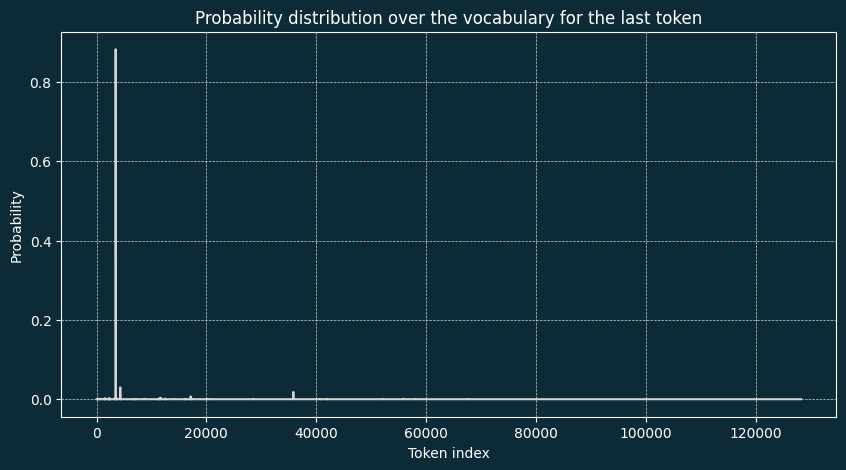

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=np.arange(len(probs[0])), y=probs[0].float().detach().cpu().numpy(), ax=ax)
style_plot(fig, ax,
           "Probability distribution over the vocabulary for the last token",
           "Token index",
           "Probability",
           grid_color = 'lightgray', grid_linestyle = '--', grid_linewidth = 0.5,
           facecolor = (13/255, 43/255, 54/255),
           text_color = 'white',
           spine_color = 'white',
           line_color = 'lightgray')

Zoom in on the token with the highest probability.

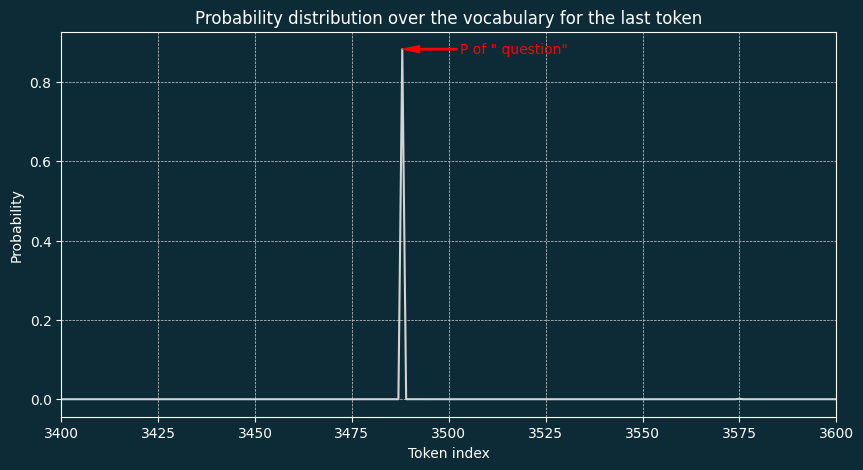

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
if model_id == model_id_llama:
    ax.set_xlim(3400, 3600)
else:
    ax.set_xlim(3350, 3450)
sns.lineplot(x=np.arange(len(probs[0])), y=probs[0].float().detach().cpu().numpy(), ax=ax)
style_plot(fig, ax,
           "Probability distribution over the vocabulary for the last token",
           "Token index",
           "Probability",
           grid_color = 'lightgray', grid_linestyle = '--', grid_linewidth = 0.5,
           facecolor = (13/255, 43/255, 54/255),
           text_color = 'white',
           spine_color = 'white',
           line_color = 'lightgray')
ax.annotate('P of " question"', xy=(idx, probs[0][idx].item()), xytext=(idx + 15, probs[0][idx].item() - 0.01), color='red',
            arrowprops=dict(edgecolor='red', facecolor='red', shrink=0.01, width=1, headwidth=5));

### Do some tokenizer experiments

So why does knowledge of the tokenizer matter?  Why can't we just use the standard tokenizer<br>
that is loaded with the model and that's it?

Let med show you how things can go wrong if you do that?

One of the things we want to do at Findable is to classify our texts according to the Norwegian<br>
NS3451 standard.  It basically assigns a three letter code to each text. 

So for instance this document:

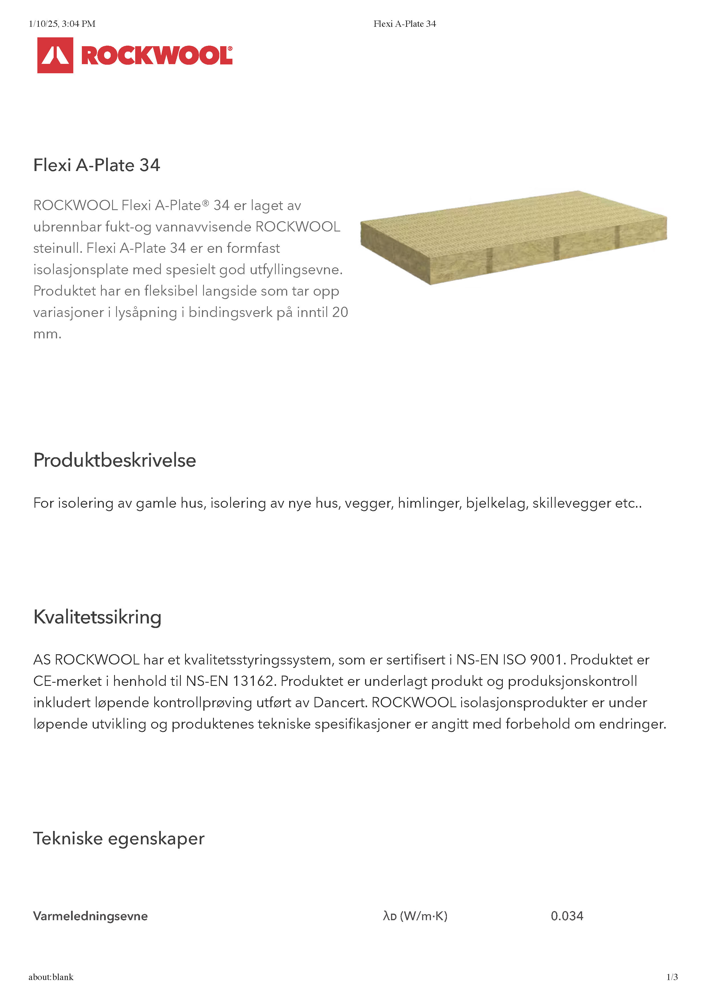

In [23]:
rockwool = PILImage.open("../data/external/Flexi A-Plate 34_Page_1.jpg")
rockwool.thumbnail((1000, 1000))
rockwool

which describes an insulation product might be given the code 248 representing:

> 2 - Bygning (building) <br>
> 24 - Bygning - Innervegger (building - inner walls) <br>
> 248 - Bygning - Innervegger - Utstyr og komplettering (building - inner walls - equipment and completions) <br>

Currently we have solved the assignment of code to documents using a standard text classifier, but we have experimented<br>
with using an LLM to do this.

The advantages of using an LLM seems clear, you could for instance base the decision not only on the text in the document,<br>
 but actually have the LLM also consider the description of the different levels in the NS3451.

So why not just finetune a model to predict the three letter code given the text?  I started doing this using the excellent<br>
meta-llama models, and that kind of works, but to my surprise the model was not more correct about the first digit than the<br>
second and third.  This seems a bit counterintuitive right?  My thought was that the model would be better at predicting the<br>
first digit, since it is a broader category, then the second, and finally the third digit wuld be the most uncertain prediction.

But no, there was hardly any difference?  Why was that?

After some frustration I realized that this is actually linked to how the llama tokenizer is set up.  Let's take a look at how<br>
the tokenizer handles single, double and three digit numbers.

Single digits

In [24]:
s = '1'

In [25]:
tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)

In [26]:
print(report_str)

String: 		1
Tokens: 		[128000, 16]
Decoded tokens: 	['<|begin_of_text|>', '1']
N tokens: 		1
N spec. tokens: 	1


So a single digit is translated into a single token.  So far as expected.  How about two digits?

In [27]:
s = '12'

In [28]:
tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)

In [29]:
print(report_str)

String: 		12
Tokens: 		[128000, 717]
Decoded tokens: 	['<|begin_of_text|>', '12']
N tokens: 		1
N spec. tokens: 	1


So the llama tokenizer treats two digits as a single token.  How about three digits?

In [30]:
s = '123'

In [31]:
tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)

In [32]:
print(report_str)

String: 		123
Tokens: 		[128000, 4513]
Decoded tokens: 	['<|begin_of_text|>', '123']
N tokens: 		1
N spec. tokens: 	1


Again, the llama tokenizer treats three digits as a single token.  How about four digits?

In [33]:
s = '1000'

In [34]:
tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)

In [35]:
print(report_str)

String: 		1000
Tokens: 		[128000, 1041, 15]
Decoded tokens: 	['<|begin_of_text|>', '100', '0']
N tokens: 		2
N spec. tokens: 	1


Take all numbers from 0 to 1000 and see how many tokens they are encoded into.

In [36]:
prnt_cnt = 0
for i in range(1000 + 1):
    s = str(i)
    tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)
    if n_tokens > 1:
        prnt_cnt += 1
        print(f"Number encoded with more than one token: {s}")
        if prnt_cnt > 10:
            break


Number encoded with more than one token: 1000


### So what was the problem?

All my categories are encoded with three digits, and they will be encoded as a __single__ token.  So the model will<br>
not be able to distinguish between the first, second and third digit.  This is why the model was not better at predicting<br>
the first digit than the second and third.

If the document is predicted as '247' and the ground truth is '248', the model will be just as wrong as if it had predicted<br>
'567'.  You get no point for getting the first and second digit right, only getting all three digits right at the same time<br>
will count as correct

### So what is the solution?

1. Use a ground truth with spaces between the digits.  This way the model will be able to distinguish between the first,<br>second and third digit.
2. Use a JSON format for the ground truth, where each digit is a separate field.  This way the model will be able to distinguish<br>
between the first, second and third digit.
3. Use a model with a tokenizer that handles numbers diffferently.  One such tokenizer is the Qwen tokenizer.


In [37]:
s = '123'
tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)
print(report_str)

String: 		123
Tokens: 		[128000, 4513]
Decoded tokens: 	['<|begin_of_text|>', '123']
N tokens: 		1
N spec. tokens: 	1


s = '1 2 3'
tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)
print(report_str)

In [39]:
s = "{'level_1': 2, 'level_2': 4, 'level_3': 8}"

In [40]:
s

"{'level_1': 2, 'level_2': 4, 'level_3': 8}"

In [41]:
tokens, decoded_tokens, report_str, n_tokens, n_spec_tokens = encode_and_decode(tokenizer, s)
print(report_str)

String: 		{'level_1': 2, 'level_2': 4, 'level_3': 8}
Tokens: 		[128000, 13922, 3374, 62, 16, 1232, 220, 17, 11, 364, 3374, 62, 17, 1232, 220, 19, 11, 364, 3374, 62, 18, 1232, 220, 23, 92]
Decoded tokens: 	['<|begin_of_text|>', "{'", 'level', '_', '1', "':", ' ', '2', ',', " '", 'level', '_', '2', "':", ' ', '4', ',', " '", 'level', '_', '3', "':", ' ', '8', '}']
N tokens: 		24
N spec. tokens: 	1


Try the Qwen tokenizer by setting the model_id above and see how it handles numbers.  It will treat each digit as a separate token.